# New Section

In [1]:
# data source: http://deepyeti.ucsd.edu/jianmo/amazon/index.html
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import time
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#########################
# 1. CLEAN REVIEWS DATA #
#########################
reviewsPath = "gdrive/MyDrive/amazon_data/Video_Games.json"
dfReviews = pd.read_json(reviewsPath, lines=True)

In [6]:
print(dfReviews.dtypes)

overall            int64
verified            bool
reviewTime        object
reviewerID        object
asin              object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
vote              object
style             object
image             object
dtype: object


In [7]:
# deal with reviewTime
dfReviews['reviewTime'] = pd.to_datetime(dfReviews['reviewTime'])
print(dfReviews['reviewTime'].min(), dfReviews['reviewTime'].max())
dfReviews['timeDiff'] = ((dfReviews['reviewTime'].max() + datetime.timedelta(days=1)) - dfReviews['reviewTime']).dt.days
print(dfReviews['timeDiff'].min(), dfReviews['timeDiff'].max())
# dfReviews['timeDiff'].plot.hist(bins=30)
dfReviews['recentness'] = (dfReviews['timeDiff'] / 90).astype(np.uint8) # 90 days = 3 months
dfRecentness = dfReviews['recentness'].value_counts(sort=False).reset_index()
dfRecentness = dfRecentness.rename(columns={'index': 'Recentness', 'recentness': 'Frequency'})
dfRecentness['Recentness'] = dfRecentness['Recentness'] + 1 # start from 1 instead of 0

1997-11-08 00:00:00 2018-10-02 00:00:00
1 7634


In [8]:
# deal with images
dfReviews['numImages'] = dfReviews['image'].str.len()
dfReviews['numImages'] = dfReviews['numImages'].fillna(0)

In [9]:
# deal with vote
dfReviews['vote'] = dfReviews['vote'].replace({',': ''}, regex=True)
dfReviews['vote'] = dfReviews['vote'].fillna(0)
dfReviews['vote'] = dfReviews['vote'].astype('float32').astype('Int32')

In [10]:
# deal with other variables
dfReviews['numStyles'] = dfReviews['style'].str.len()
dfReviews['numStyles'] = dfReviews['numStyles'].fillna(0)

dfReviews['reviewTextLength'] = dfReviews['reviewText'].str.len()
dfReviews['summaryLength'] = dfReviews['summary'].str.len()

In [11]:
# final touch-up
dfReviews = dfReviews.astype({'overall': np.uint8, 'numImages': np.uint8, 'reviewTextLength': 'Int32',
                              'summaryLength': 'Int32', 'numStyles': np.uint8})
dfReviews = dfReviews.rename(columns={'overall': 'rating'})
dfReviews = dfReviews[['asin', 'rating', 'verified', 'timeDiff', 'recentness', 'reviewTime', 'reviewerID',
                       'reviewText', 'reviewTextLength', 'summary', 'summaryLength', 'vote', 'numStyles', 'numImages']]
print(dfReviews.dtypes)

asin                        object
rating                       uint8
verified                      bool
timeDiff                     int64
recentness                   uint8
reviewTime          datetime64[ns]
reviewerID                  object
reviewText                  object
reviewTextLength             Int32
summary                     object
summaryLength                Int32
vote                         Int32
numStyles                    uint8
numImages                    uint8
dtype: object


In [12]:
dfReviews.to_json('gdrive/MyDrive/amazon_data/clean_Video_Games.json', orient='split')

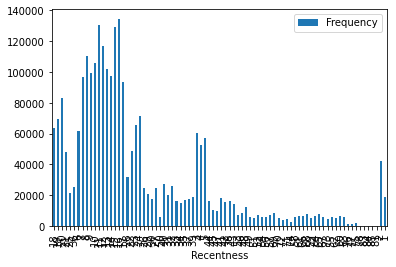

In [13]:
##################
# 1.1 SOME PLOTS #
##################
# plot dfRecentness
dfRecentness.plot.bar(x='Recentness', y='Frequency')

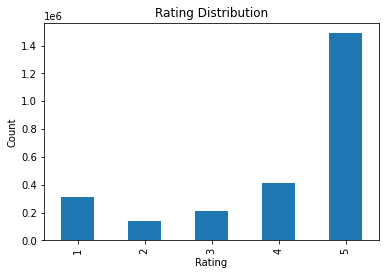

In [14]:
# plot rating distribution
dfReviews['rating'].value_counts().sort_index().plot(kind='bar', title='Rating Distribution',
                                                     xlabel='Rating', ylabel='Count')

In [ ]:
#####################################
# TODO 1.2 SENTIMENT ANALYSIS ON REVIEWS #
#####################################
# code help: https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook
sia = SentimentIntensityAnalyzer()

# get polarity score on dfReviews
t0 = time.time()
summaryPolarity = {}
for i, row in dfReviews.iterrows():
    text = str(row['reviewText'])
    ps = sia.polarity_scores(text)
    ps['text'] = text
    summaryPolarity[i] = ps
t1 = time.time()
print(t1-t0)
dfSummaryPolarity = pd.DataFrame(summaryPolarity).T
# dfSummaryPolarity = dfSummaryPolarity.reset_index().rename(columns={'index': 'Id'})
# dfSummaryPolarity = dfSummaryPolarity.merge(dfReviews, how='left')

In [15]:
##################################
# 1.3 GET AGGREGATE REVIEWS DATA #
##################################
# get mean rating and total counts per asin per verified
gc = dfReviews.groupby(['asin', 'verified'], as_index=False).agg({'rating': 'mean',
                                                                  'reviewerID': 'count'
                                                                  })
gc = gc.rename(columns={'rating': 'avgRating', 'reviewerID': 'numReviews'})
gc = gc.sort_values(by=['numReviews', 'asin', 'verified'], ascending=[False, True, True], ignore_index=True)

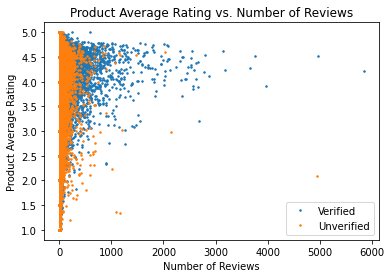

In [19]:
# plot scatterplot of ratings vs. number of reviews per product for verified and unverified reviews respectively
gcVerified = gc.loc[gc['verified'] == True]
gcUnverified = gc.loc[gc['verified'] == False]

plt.figure()
plt.plot(gcVerified['numReviews'], gcVerified['avgRating'], '.', markersize=3, label='Verified')
plt.plot(gcUnverified['numReviews'], gcUnverified['avgRating'], '.', markersize=3, label='Unverified')
plt.title('Product Average Rating vs. Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Product Average Rating')
plt.legend()
plt.show()

In [20]:
#####################
# 2. CLEAN METADATA #
#####################
dfMeta = pd.read_json('gdrive/MyDrive/amazon_data/meta_Video_Games.json', lines=True)

In [23]:
print(dfMeta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84819 entries, 0 to 84818
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         84819 non-null  object
 1   tech1            84819 non-null  object
 2   description      84819 non-null  object
 3   fit              84819 non-null  object
 4   title            84819 non-null  object
 5   also_buy         84819 non-null  object
 6   tech2            84819 non-null  object
 7   brand            84819 non-null  object
 8   feature          84819 non-null  object
 9   rank             84819 non-null  object
 10  also_view        84819 non-null  object
 11  main_cat         84819 non-null  object
 12  similar_item     84819 non-null  object
 13  date             84819 non-null  object
 14  price            84819 non-null  object
 15  asin             84819 non-null  object
 16  imageURL         84819 non-null  object
 17  imageURLHighRes  84819 non-null

In [24]:
# add variable: contains image or not
dfMeta['numImages'] = dfMeta['imageURL'].str.len()
dfMeta['numHighResImages'] = dfMeta['imageURLHighRes'].str.len()

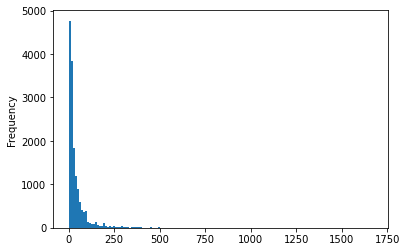

In [25]:
# deal with price
def convert_float(x):
    try:
        x = x.replace('$', '').replace(',', '')
        return float(x)
    except:
        return np.nan
dfMeta['price'] = dfMeta['price'].replace({'': np.nan})
# dfMeta['price'] = dfMeta['price'].str.replace('$', '', regex=True)
# dfMeta['price'] = dfMeta['price'].str.replace(',', '', regex=True)
dfMeta['price'] = dfMeta['price'].apply(lambda p: convert_float(p))
dfMeta['price'].plot.hist(bins=150)

In [30]:
# clean rank column by splitting into rank categories and rank numbers
dfMetaRank = dfMeta['rank'].str.split('in', n=1, expand=True)
dfMetaRank = dfMetaRank.rename(columns={0: 'nums', 1: 'categories'})

In [31]:
# clean rank categories
dfMetaRank['categories'] = dfMetaRank['categories'].str.rstrip('(')
dfMetaRank['categories'] = dfMetaRank['categories'].replace({'amp;': ''}, regex=True) # ',': ''
dfMetaRank['categories'] = dfMetaRank['categories'].str.strip()
print(dfMetaRank['categories'].value_counts())
# take out irrelevant rows
# dfMetaRank = dfMetaRank.loc[(dfMetaRank['categories'].str.contains('Video Games')) |
#                             dfMetaRank['categories'].isna()]

Video Games                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   118
Sports & Outdoors                                                                                                                                                                                                                                                                                                                                                                     

In [40]:
# turn rank numbers into Int64
dfMetaRank['nums'] = dfMetaRank['nums'].replace({',': '', ' ': '', '\n': '', '\t': ''}, regex=True)

# deal with special case
dfMetaRank['nums'].loc[dfMetaRank['nums']=='productDescription{color:'] = np.nan

dfMetaRank['nums'] = dfMetaRank['nums'].astype('float').astype('Int64')

In [42]:
# merge rank info into original metadata
dfMeta = dfMeta.merge(dfMetaRank, left_index=True, right_index=True)

In [44]:
# drop rows with duplicate asin
dfMetaDup = dfMeta.loc[dfMeta.duplicated(['asin'])]
dfMetaDup = dfMeta.loc[dfMeta['asin'].isin(list(dfMetaDup['asin']))]
dfMetaDup = dfMetaDup.sort_values(by='asin')
dfMeta = dfMeta.drop_duplicates(['asin'], ignore_index=True)

In [54]:
# final touch-up
dfMeta = dfMeta.astype({'numImages': np.uint8, 'numHighResImages': np.uint8})
dfMeta = dfMeta[['asin', 'title', 'brand', 'price', 'nums',
                 'numImages', 'numHighResImages',
                 'description', 'fit', 'also_buy',  #
                 'feature', 'also_view', 'details', 'similar_item'  #
                 ]]
dfMeta = dfMeta.rename(columns={'nums': 'rank'})

In [55]:
print(dfMeta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71911 entries, 0 to 71910
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   asin              71911 non-null  object 
 1   title             71911 non-null  object 
 2   brand             71911 non-null  object 
 3   price             11908 non-null  float64
 4   rank              499 non-null    Int64  
 5   numImages         71911 non-null  uint8  
 6   numHighResImages  71911 non-null  uint8  
 7   description       71911 non-null  object 
 8   fit               71911 non-null  object 
 9   also_buy          71911 non-null  object 
 10  feature           71911 non-null  object 
 11  also_view         71911 non-null  object 
 12  details           71804 non-null  object 
 13  similar_item      71911 non-null  object 
dtypes: Int64(1), float64(1), object(10), uint8(2)
memory usage: 6.8+ MB
None


In [56]:
########################################
# 3. COMBINE REVIEWS DATA AND METADATA #
########################################
dfAll = dfReviews.merge(dfMeta, how='inner', on='asin')
dfAll = dfAll.sort_values(by=['asin', 'timeDiff'])

In [58]:
print(dfAll.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2561673 entries, 2483082 to 2413278
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   asin              object        
 1   rating            uint8         
 2   verified          bool          
 3   timeDiff          int64         
 4   recentness        uint8         
 5   reviewTime        datetime64[ns]
 6   reviewerID        object        
 7   reviewText        object        
 8   reviewTextLength  Int32         
 9   summary           object        
 10  summaryLength     Int32         
 11  vote              Int32         
 12  numStyles         uint8         
 13  numImages_x       uint8         
 14  title             object        
 15  brand             object        
 16  price             float64       
 17  rank              Int64         
 18  numImages_y       uint8         
 19  numHighResImages  uint8         
 20  description       object        
 21  fi